In [3]:
import os

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle

from src.CPQAOA import CP_QAOA
from src.QAOA import QAOA
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo)

In [2]:
def simulate(datapoint):
    # Defining topology
    my_chain = Chain(N_qubits=datapoint['N'])
    my_chain.set_initialization_strategy(strategy=datapoint['init_strat'])
    
    # Deciding between grid and 1d chain topology
    my_topology = my_chain
    
    # Generating random problem instance 
    expected_returns, covariances = portfolio_metrics(n=datapoint['N'], seed=datapoint['seed'])
    
    # Retrieving C_min, C_max and corresponding states for original portfolio problem
    constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=datapoint['N'],
                                                                k=datapoint['k'],
                                                                mu=expected_returns,
                                                                sigma=covariances,
                                                                alpha=datapoint['alpha'])
    
    portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
    #full_space_max_cost = full_result['c_max']
    portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])

    # Generating QUBO corresponding to current problem instance
    Q, offset = get_qubo(mu=expected_returns,
                         sigma=covariances, 
                         alpha=datapoint['alpha'],
                         lmbda=lmbda+1e-8, # Adding small constant purposely
                         k=datapoint['k'])
    QUBO_limits = qubo_limits(Q=Q,offset=offset)
    qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
    qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
    check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=datapoint['alpha'], k=datapoint['k'])
    qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])

    
    if not portfolio_subspace_min_state_str == qubo_min_state_str:
        raise RuntimeError(f'portfolio_subspace_min_state_str: {portfolio_subspace_min_state_str}, qubo_min_state_str={qubo_min_state_str}'+f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')
    
    if not np.isclose(qubo_min_cost,portfolio_subspace_min_cost):
        raise RuntimeError(f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')
    
    if not qubo_max_cost >= portfolio_subspace_max_cost:
        raise RuntimeError(f'Max. cost of qubo: {qubo_max_cost}, max. cost of portfolio subspace: {portfolio_subspace_max_cost} (should be qubo max. >= constrained portfolio max)')

    
    # Generating instances of ansatz'
    CP_z_phase_ansatz = CP_QAOA(N_qubits=datapoint['N'],
                     cardinality=datapoint['k'],
                     layers=datapoint['layers'],
                     topology=my_topology,
                     QUBO_matrix=Q,
                     with_next_nearest_neighbors=datapoint['w_nnn'],
                     with_gradient=True,
                     approximate_hamiltonian=True,
                     with_z_phase=datapoint['w_z_phase'])
    
    NORMAL_ansatz = QAOA(N_qubits=datapoint['N'],
                     layers=datapoint['layers'],
                     QUBO_matrix=Q,
                     QUBO_offset=offset,
                     constraining_mixer=False,
                     Topology=my_topology)
    
    # Choosing optimizer for scipy
    available_methods = ['COBYLA', 'Nelder-Mead', 'BFGS']
    optimizer_method = available_methods[0]
    
    # Generating callback function for plotting
    CP_z_phase_costs = [] # Normalized costs
    CP_z_phase_probs = [] # probability of optimal state
    def CP_z_phase_callback_function(x):
        _dict_ = CP_z_phase_ansatz.get_state_probabilities(flip_states=False)
        # N.B. Normalizing w. respect to full space max cost
        _cost_ = normalized_cost(result=_dict_,
                                 QUBO_matrix=Q,
                                 QUBO_offset=offset,
                                 max_cost=portfolio_subspace_max_cost, 
                                 min_cost=qubo_min_cost)
        if portfolio_subspace_min_state_str in list(_dict_.keys()):
            CP_z_phase_probs.append(_dict_[portfolio_subspace_min_state_str])
        else:
            CP_z_phase_probs.append(0)
        CP_z_phase_costs.append(_cost_)
        
    # Generating callback function for plotting
    NORMAL_costs = [] # Normalized costs
    NORMAL_probs = [] # probability of optimal state
    def NORMAL_callback_function(x):
        _dict_ = NORMAL_ansatz.get_state_probabilities(flip_states=False)
        # N.B. Normalizing w. respect to full space max cost
        _cost_ = normalized_cost(result=_dict_,
                                 QUBO_matrix=Q,
                                 QUBO_offset=offset,
                                 max_cost=portfolio_subspace_max_cost, 
                                 min_cost=qubo_min_cost)
        if portfolio_subspace_min_state_str in list(_dict_.keys()):
            NORMAL_probs.append(_dict_[portfolio_subspace_min_state_str])
        else:
            NORMAL_probs.append(0)
        NORMAL_costs.append(_cost_)
    
    # Generating initial guess for rotation angles
    np.random.seed(datapoint['seed'])
    theta_min, theta_max = -2*np.pi, 2*np.pi
    N_angles = datapoint['layers'] * len(my_topology.get_NN_indices())
    if datapoint['w_nnn']:
        N_angles = datapoint['layers'] * len(my_topology.get_NNN_indices())
    if datapoint['w_z_phase']:
        N_angles += datapoint['N'] * datapoint['layers']
    CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
    np.random.seed(datapoint['seed'])
    N_angles = 2 * datapoint['layers']
    NORMAL_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
    
    """CP_z_phase_res = sc.optimize.minimize(fun=CP_z_phase_ansatz.get_cost, 
                                      x0=CP_z_phase_theta_i,
                                      method=optimizer_method,
                                      options={'disp': False, 
                                               'maxiter': datapoint['max_iter']},
                                      callback=CP_z_phase_callback_function)"""
    
    NORMAL_res = sc.optimize.minimize(fun=NORMAL_ansatz.get_cost, 
                                      x0=NORMAL_theta_i,
                                      method=optimizer_method,
                                      options={'disp': False, 
                                               'maxiter': datapoint['max_iter']},
                                      callback=NORMAL_callback_function)

    return {'N': datapoint['N'],
            'k': datapoint['k'],
            'alpha': datapoint['alpha'],
            'max_iter': datapoint['max_iter'],
            'topology': my_topology,
            'seed': datapoint['seed'],
            'next nearest neighbor': datapoint['w_nnn'],
            'layers': datapoint['layers'],
            'z-phase': datapoint['w_z_phase'],
            'QAOA': (NORMAL_probs,NORMAL_costs,NORMAL_res),
            'CP_VQA': (CP_z_phase_probs, CP_z_phase_costs, 5)}

In [4]:
# Number of Qubits 
N_vals = 10
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Maximal number of iterations for classical solver
max_iter=1500
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = True
# Number of layer repetitions
layer_dict = {3:1, 4:1, 5:1,
              6:2, 7:2, 8:2, 
              9:2, 10:3, 11:3, 
              12:3, 13:3, 14:3,
              15:4, 16:4, 17:4}


initialization_strategies = {N_qubits : np.array([1 if i%2 == 1 else 0 for i in range(N_qubits)]) 
                             for N_qubits in range(min(list(layer_dict.keys())),max(list(layer_dict.keys()))+1)}


N_SEEDS = 1
N_jobs = os.cpu_count()-1
N = N_vals
k = N // 2
seed = 3

dp = {'N': N, 'k': k, 'alpha': alpha, 'max_iter': max_iter, 'seed': seed, 'w_nnn': w_next_nearest_neighbors, 
      'layers': layer_dict[N], 'w_z_phase': False, 'init_strat': initialization_strategies[N]}
        
res = simulate(dp)
QAOA_res, CP_VQA_res = res['QAOA'], res['CP_VQA']

QAOA_probs, QAOA_costs, QAOA_solver_res = QAOA_res 
CP_VQA_probs, CP_VQA_costs, CP_VQA_solver_res = CP_VQA_res

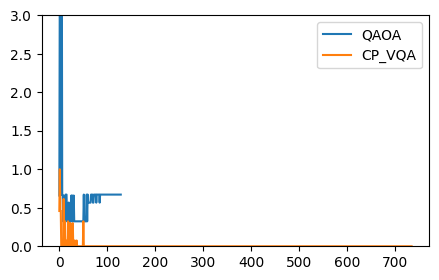

In [30]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot([it for it in range(len(QAOA_costs))], QAOA_costs, label='QAOA')
ax.plot([it for it in range(len(CP_VQA_costs))], CP_VQA_costs, label='CP_VQA')
ax.legend()
ax.set_ylim(0,3)
plt.show()

In [192]:
from typing import *
from qiskit.quantum_info import Operator, SparsePauliOp

def get_qiskit_H(Q: np.ndarray):
    """ Generates H = \sum_ij q_ij(I_i-Z_i)/2(I_j-Z_j)/2 """

    def get_ij_term(i: int, j: int, Q: np.ndarray) -> List[Tuple[str, float]]:
        N = Q.shape[0]
        I_term = ''.join('I' for qubit_idx in range(N))
        Z_i_term = ''.join('Z' if qubit_idx == i else 'I' for qubit_idx in range(N))
        Z_j_term = ''.join('Z' if qubit_idx == i else 'I' for qubit_idx in range(N))
        # Pauli matrices are idempotent: x^2=y^2=z^2=I
        if i == j:
            Z_ij_term = I_term
        else:
            Z_ij_term = ''.join('Z' if qubit_idx == i or qubit_idx == j else 'I' for qubit_idx in range(N))
        total_ij_term = [(I_term, Q[i, j] / 4), (Z_i_term, -Q[i, j] / 4), (Z_j_term, -Q[i, j] / 4),
                         (Z_ij_term, Q[i, j] / 4)]
        return total_ij_term
    H = []
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            H += get_ij_term(i, j, Q)
    return SparsePauliOp.from_list(H)
from scipy.sparse import csc_matrix, csr_matrix, kron, identity


def get_normal_H(Q: np.ndarray, flip: bool = False) -> np.ndarray:
    """ Generates H = \sum_ij q_ij(I_i-Z_i)/2(I_j-Z_j)/2 
    If flip is True, the same convention for indexing as in Qiskit is assumed
    where MSB is the right most qubit in a string.
    """
    I = identity(2, format='csr', dtype=np.float32)
    Z = csr_matrix(np.array([[1, 0], [0, -1]], dtype=np.float32))
    gate_map = {'Z': Z, 'I': I}
    def get_term(i: int):
        N = Q.shape[0]
        if i == N - 1:
            _mat_rep_ = gate_map['Z']
            _after_I_ = identity(2 ** (N - 1), format='csr')
            _mat_rep_ = kron(_mat_rep_, _after_I_)
        else:
            _before_I_ = identity(2 ** (N - i - 1), format='csr')
            _mat_rep_ = kron(_before_I_, gate_map['Z'])
            _after_I_ = identity(2 ** i, format='csr')
            _mat_rep_ = kron(_mat_rep_, _after_I_)
        return csr_matrix(_mat_rep_)

    def get_ij_term(i: int, j: int, Q: np.ndarray) -> csc_matrix:
        N = Q.shape[0]
        I_term = identity(2**Q.shape[0], format='csr', dtype=np.float32)
        if flip:
            Z_i_term = get_term(i=N-i-1)
            if i == j:
                Z_ij_term = I_term
                Z_j_term = Z_i_term
            else:
                Z_j_term = get_term(i=N-j-1)
                Z_ij_term = get_term(i=N-i-1) @ get_term(i=N-j-1)
            return Q[i, j] / 4.0 * (I_term - Z_i_term - Z_j_term + Z_ij_term)
        Z_i_term = get_term(i=i)
        if i == j:
            Z_ij_term = I_term
            Z_j_term = Z_i_term
        else:
            Z_j_term = get_term(i=j)
            Z_ij_term = get_term(i=i) @ get_term(i=j)
        return Q[i, j] / 4.0 * (I_term - Z_i_term - Z_j_term + Z_ij_term)
        
        
    
    H = csr_matrix(np.zeros(shape=(2**Q.shape[0], 2**Q.shape[1]), dtype=np.float32))
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            H += get_ij_term(i, j, Q).astype(np.float32)
    return H.todense()



In [185]:
N=12
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states for original portfolio problem
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=N//2,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
#full_space_max_cost = full_result['c_max']
portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances, 
                     alpha=alpha,
                     lmbda=lmbda+1e-8, # Adding small constant purposely
                     k=k)

In [186]:
H = np.array(Operator(get_qiskit_H(Q))).astype(np.float32)

C:\Users\madse\AppData\Local\Temp\ipykernel_13680\3460625864.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  H = np.array(Operator(get_qiskit_H(Q))).astype(np.float32)


In [193]:
H2 = get_normal_H(Q, flip=True)

In [191]:
np.allclose(H,H2)

True

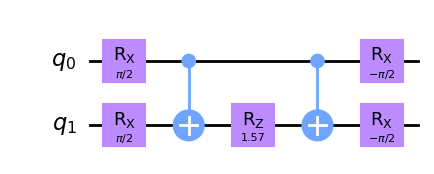

In [15]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import RXXGate, RYYGate
from qiskit.visualization import circuit_drawer

# Step 1: Create a 2-qubit Quantum Circuit
qc = QuantumCircuit(2)

# Step 2: Add an RXX gate with a specified rotation angle (in radians)
rotation_angle = 1.57  # For example, π/2 radians
qc.append(RYYGate(rotation_angle), [0, 1])

# Step 3: Decompose the circuit
decomposed_circuit = transpile(qc, basis_gates=['rz', 'cx', 'rx', 'ry', 'h'], optimization_level=3)

# Step 4: Plot the circuit
circuit_drawer(decomposed_circuit, output='mpl', style={'backgroundcolor': '#FFFFFF'})


In [57]:
from itertools import combinations

def generate_bit_strings(N, k):
    """
    Generate all bit strings of length N with k ones.

    Parameters:
    N (int): The length of the bit strings.
    k (int): The number of ones in each bit string.

    Returns:
    List[str]: A list of all bit strings of length N with k ones (formatted as ints).
    """
    bit_strings = []
    for positions in combinations(range(N), k):
        bit_string = ['0'] * N
        for pos in positions:
            bit_string[pos] = '1'
        bit_strings.append(int(''.join(bit_string),2))
    return bit_strings